In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
# Method A:
# poetry add common
# # So common is a third-party package that you just installed via Poetry. The package common 
# # version 0.1.2 is now installed in your virtual environment.

# Method B: If you meant to import your own common.py file instead of installing the package:
# 1. Remove the package:
# bash
# poetry remove common
# 2. Create your own common.py:
from common_dse import get_backtest_result, get_dual_backtest_result, get_hodl_result, max_drawdown, get_cache_path, save_cache_data, load_cache_data

In [6]:
# Input
exchanges_markets = [
    {
        "binance": "BTCUSDT",
        "bitmex": "XBTUSD",
        "apollox": "BTCUSDT",
        "drift": "BTC-PERP"
    },
    {
        "binance": "ETHUSDT",
        "bitmex": "ETHUSD",
        "apollox": "ETHUSDT",
        "drift": "ETH-PERP"
    },
    {
        "binance": "SOLUSDT",
        "bitmex": "SOLUSD",
        "apollox": "SOLUSDT",
        "drift": "SOL-PERP"
    },
    {
        "binance": "XRPUSDT",
        "bitmex": "XRPUSD",
        "apollox": "XRPUSDT",
        "drift": "XRP-PERP"
    },
    {
        "binance": "BNBUSDT",
        "bitmex": "BNBUSD",
        "apollox": "BNBUSDT",
        "drift": "BNB-PERP"
    },
]

hedge_map = {
    "binance": "bitmex",
    "bitmex": "binance",
    "apollox": "binance",
    "drift": "binance"
}

funding_freq_map = {
    "BTCUSDT": 8,
    "XBTUSD": 8,
    "BTCUSDT": 8,
    "BTC-PERP": 1,
    "ETHUSDT": 8,
    "ETHUSD": 8,
    "ETHUSDT": 8,
    "ETH-PERP": 1,
    "SOLUSDT": 8,
    "SOLUSD": 8,
    "SOLUSDT": 8,
    "SOL-PERP": 1,
    "XRPUSDT": 8,
    "XRPUSD": 8,
    "XRPUSDT": 8,
    "XRP-PERP": 1,
    "BNBUSDT": 8,
    "BNBUSD": 8,
    "BNBUSDT": 8,
    "BNB-PERP": 1,
}

benchmark_exchange = "binance"
benchmark_markets = [entry[benchmark_exchange] for entry in exchanges_markets]

In [7]:
# Compute all combinations of funding rate PNL

# Initial variables
min_time = datetime.fromisoformat('2023-08-01').timestamp()
max_time = datetime.fromisoformat('2024-02-29').timestamp()

data_df_map = {}
results = {}

leverages = [1, 3, 5, 7]

# Read data from file
for exchanges_market in exchanges_markets:
    for exchange, market in exchanges_market.items():
        data_df = load_cache_data(exchange, market)
        
        if exchange not in data_df_map:
            data_df_map[exchange] = {}
        data_df_map[exchange][market] = data_df

# calculate min max time
for exchanges_market in exchanges_markets:
    for exchange, market in exchanges_market.items():
        data_df = data_df_map[exchange][market]
        min_time = max(min_time, data_df["timestamp"].min())
        max_time = min(max_time, data_df["timestamp"].max())

# Calculate funding rate backtest result
for exchanges_market in exchanges_markets:
    for exchange, market in exchanges_market.items():
        short_df = data_df_map[exchange][market]
        short_df['datetime'] = short_df['datetime'].apply(lambda x: pd.to_datetime(x))
        short_df = short_df[
            (short_df["timestamp"] >= min_time) & (short_df["timestamp"] <= max_time)
        ]
        short_df = short_df.sort_values(by='datetime', ascending=True)
        short_df = short_df.reset_index(drop=True)
        
        long_exchange = hedge_map[exchange]
        long_market = exchanges_market[long_exchange]
        long_df = data_df_map[long_exchange][long_market]
        long_df['datetime'] = long_df['datetime'].apply(lambda x: pd.to_datetime(x))
        long_df = long_df[
            (long_df["timestamp"] >= min_time) & (long_df["timestamp"] <= max_time)
        ]
        long_df = long_df.sort_values(by='datetime', ascending=True)
        long_df = long_df.reset_index(drop=True)

        if exchange not in results:
            results[exchange] = {}
        if market not in results[exchange]:
            results[exchange][market] = {}

        for leverage in leverages:
            if leverage == 1:
                result_df = get_backtest_result(short_df, leverage)
            else:
                (result_df, _, _) = get_dual_backtest_result(long_df, short_df, funding_freq_map[long_market], funding_freq_map[market], leverage)
            results[exchange][market][leverage] = result_df

In [8]:
# Calculate HODL backtest result
for market in benchmark_markets:
    data_df = data_df_map[benchmark_exchange][market]
    data_df['datetime'] = data_df['datetime'].apply(lambda x: pd.to_datetime(x))
    data_df = data_df[
        (data_df["timestamp"] >= min_time) & (data_df["timestamp"] <= max_time)
    ]
    data_df = data_df.sort_values(by='datetime', ascending=True)
    data_df = data_df.reset_index(drop=True)

    results[benchmark_exchange][market]['hodl'] = get_hodl_result(data_df)

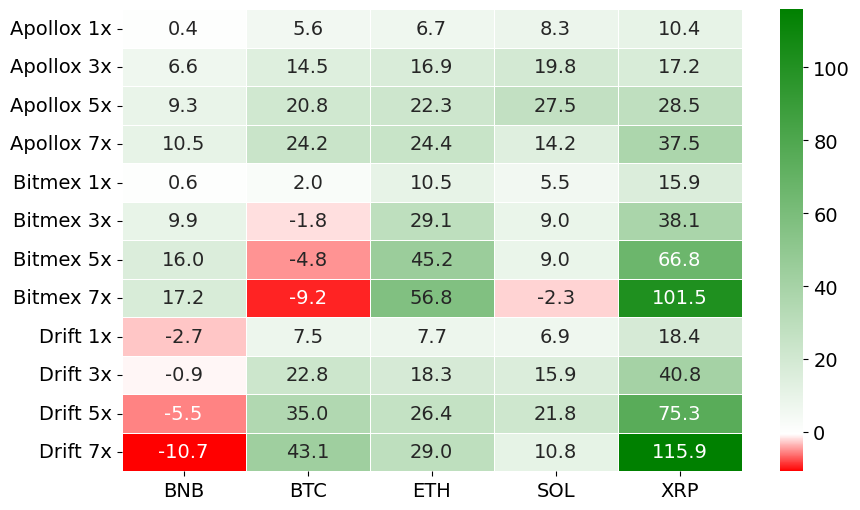

In [10]:
import seaborn as sns
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

# Example PNL data (replace with your actual data)
data = {
    'market': [],
    'key': [],
    'pnl': []
}

for exchanges_market in exchanges_markets:
    for exchange, market in exchanges_market.items():
        if exchange == benchmark_exchange:
            continue
        else:
            market_name = market.replace("USDT", "").replace("-PERP", "").replace("USD", "")
            market_name = 'BTC' if market_name == "XBT" else market_name
            for leverage in leverages:
                key = f"{exchange.capitalize()} {leverage}x"
                value = results[exchange][market][leverage]['final_pnl'].iloc[-1] * 100
                data["market"].append(market_name)
                data["key"].append(key)
                data['pnl'].append(value)

# for market in benchmark_markets:
#     market_name = market.replace("USDT", "").replace("-PERP", "").replace("USD", "")
#     market_name = 'BTC' if market_name == "XBT" else market_name
    
#     key = "hodl"
#     value = results[benchmark_exchange][market]['hodl']['pnl'].iloc[-1] * 100

#     data['market'].append(market_name)
#     data["key"].append(key)
#     data['pnl'].append(value)
            
df = pd.DataFrame(data)

# Pivot the DataFrame to prepare for heatmap
heatmap_data = df.pivot_table(index='key', columns='market', values='pnl')

# Create the heatmap using Seaborn
plt.figure(figsize=(10, 6))

# Creating a custom color map
colors = ["red", "white", "green"]  # Define the colors
n_bins = 1000  # Increase for finer resolution
cmap_name = "rwg"
position = [0, 0.08, 1]
cmap = LinearSegmentedColormap.from_list(cmap_name, list(zip(position, colors)), N=n_bins)

heatmap = sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap=cmap, linewidths=0.5, annot_kws={"size": 14})

# Adjust font size of color bar labels
cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=14)

# Adding labels and title
heatmap.set_xlabel('')
heatmap.set_ylabel('')

heatmap.set_xticklabels(heatmap.get_xticklabels(), fontsize=14)
heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize=14)

plt.savefig(f'./figs/pnl_heatmap.png', format='png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


In [12]:
import numpy as np
from common_dse import max_drawdown, sharpe_ratio

# Input
high_value_keys = [
    'drift_XRP-PERP_7',
    'bitmex_ETHUSD_7',
    'drift_BTC-PERP_7',
    'apollox_SOLUSDT_5',
    'bitmex_BNBUSD_7'
]

# Summary
pnl = {}
max_dd = {}
sharpe = {}

risk_free_return = 0.0654 / 2 # Compound V3 USDC pool (Aug 2023 - Feb 2024)

for key in high_value_keys:
    [exchange, market, leverage] = key.split('_')
    result_df = results[exchange][market][int(leverage)]

    pnl_values = result_df['final_pnl']
    pnl_changes = pnl_values.diff().fillna(0)
    last_pnl = pnl_values.iloc[-1]
    hr_interval = result_df['datetime'].diff().mean().total_seconds() / (60 * 60)

    pnl[key] = last_pnl
    max_dd[key] = max_drawdown(pnl_values)
    sharpe[key] = sharpe_ratio(pnl_changes, last_pnl, risk_free_return, hr_interval)

    # print("STDEV: ", pnl_changes.std() * np.sqrt(24 / hr_interval * 365) * 100)

for market in benchmark_markets:
    key = f"HODL {benchmark_exchange}_{market}"       

    pnl_values = results[benchmark_exchange][market]['hodl']['pnl']
    pnl_changes = results[benchmark_exchange][market]['hodl']['pnl'].diff().fillna(0)
    last_pnl = results[benchmark_exchange][market]['hodl']['pnl'].iloc[-1]
    hr_interval = results[benchmark_exchange][market]['hodl']['datetime'].diff().mean().total_seconds() / (60 * 60)

    pnl[key] = last_pnl
    max_dd[key] = max_drawdown(pnl_values)
    sharpe[key] = sharpe_ratio(pnl_changes, last_pnl, risk_free_return, hr_interval)

sorted_pnl = sorted(pnl.items(), key=lambda x:x[1])
print("Sorted PNL: ")
for item in sorted_pnl:
    print(f"{item[0]} -> {item[1] * 100:.2f}%")

print("====")
sorted_max_dd = sorted(max_dd.items(), key=lambda x:-x[1])
print("Sorted Max Drawdown: ")
for item in sorted_max_dd:
    print(f"{item[0]} -> {item[1] * 100:.2f}%")
    
print("====")
sorted_sharpe_ratio = sorted(sharpe.items(), key=lambda x:x[1])
print("Sorted Sharpe Ratio: ")
for item in sorted_sharpe_ratio:
    print(f"{item[0]} -> {item[1]:.2f}")

Sorted PNL: 
HODL binance_XRPUSDT -> -12.84%
bitmex_BNBUSD_7 -> 17.23%
apollox_SOLUSDT_5 -> 27.52%
drift_BTC-PERP_7 -> 43.12%
bitmex_ETHUSD_7 -> 56.82%
HODL binance_BNBUSDT -> 70.65%
HODL binance_ETHUSDT -> 86.76%
HODL binance_BTCUSDT -> 115.74%
drift_XRP-PERP_7 -> 115.90%
HODL binance_SOLUSDT -> 392.80%
====
Sorted Max Drawdown: 
bitmex_ETHUSD_7 -> -0.77%
apollox_SOLUSDT_5 -> -1.43%
drift_BTC-PERP_7 -> -1.66%
drift_XRP-PERP_7 -> -1.92%
bitmex_BNBUSD_7 -> -8.38%
HODL binance_BTCUSDT -> -16.18%
HODL binance_BNBUSDT -> -17.15%
HODL binance_ETHUSDT -> -18.28%
HODL binance_XRPUSDT -> -32.97%
HODL binance_SOLUSDT -> -33.83%
====
Sorted Sharpe Ratio: 
HODL binance_XRPUSDT -> -0.54
HODL binance_SOLUSDT -> 2.05
HODL binance_BNBUSDT -> 2.06
HODL binance_ETHUSDT -> 2.25
HODL binance_BTCUSDT -> 2.92
bitmex_BNBUSD_7 -> 3.87
apollox_SOLUSDT_5 -> 7.18
drift_BTC-PERP_7 -> 9.15
bitmex_ETHUSD_7 -> 11.79
drift_XRP-PERP_7 -> 15.85
